
#NSTD84212 Exam
# 30TH November 2021
# Question 1

In [ ]:
!pip install pyLDAvis

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models as pygen

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stop_words.extend(['make', 'want', 'seem', 'run', 'need', 'even', 'not', 'would', 'say', 'could', '_', 
                'be', 'know', 'go', 'get', 'do','get','far','also','way','app','usd','eur','jai','hind','jai_hind',
'done', 'try', 'many','from', 'subject', 're', 'edu','some', 'nice', 'thank','singh','mast','untuk','apne','nise','vgood',
'think', 'see', 'rather', 'lot', 'line', 'even', 'also', 'may', 'use','goog','nce','aap','thik','hai','setu','aarogya_setu','aarogya',
'take', 'come','recommend','recommended','paypal','paytm', 'let','ad','add'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import files
data = files.upload()

Saving Capitec_Absa_Reviews.csv to Capitec_Absa_Reviews.csv


In [ ]:
data_ = pd.read_csv ('Capitec_Absa_Reviews.csv')

1. Analyse Capitec's negative reviews (1-2 stars) to find out what customers do not like about 
their mobile banking app or experience. 

a. Use Latent Dirichlet allocation (LDA) to create a topic model with five topics to 
complete this task. Interpret each of the topics to explain to management the issues 
you have uncovered. 

In [ ]:
data_.head()

,appId,Date_Posted,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,sortOrder,thumbsUpCount,userImage,userName
0,capitec.acuity.mobile.prod,2021/10/08 13:11,USELESS APP!!!!. Everytime I try to log in it ...,2021/10/08 15:29,"Hi again Beyers, we are truly sorry to hear th...",2.0.93,gp:AOqpTOHMG6X1P3x5YrUGvSW54v9RhneKsCTU2v-BmPv...,1,newest,7,https://play-lh.googleusercontent.com/a-/AOh14...,Beyers Terblanche
1,capitec.acuity.mobile.prod,2021/10/07 11:04,"Horrible experience, the app is ALWAYS offline...",2021/10/07 12:47,"Hi Morweshadi, we are sorry to learn about you...",2.0.93,gp:AOqpTOFR8VLOxY4sW5NMNiN8lUIlHJmnYFyzww5i1Vw...,1,newest,273,https://play-lh.googleusercontent.com/a-/AOh14...,morweshadi tladi
2,capitec.acuity.mobile.prod,2021/10/08 16:11,Hello.App says currently unavailable. I see al...,2021/10/08 18:51,"Hi Asif, we regret learning of your negative A...",2.0.93,gp:AOqpTOHfVbsTPt9OxR5Muun0xKBoIHQVsD17gOSgPxY...,1,newest,6,https://play-lh.googleusercontent.com/a-/AOh14...,Asif Muhammad
3,capitec.acuity.mobile.prod,2021/09/10 16:20,App says currently unavailable. I see alot of ...,2021/09/10 17:19,"Hi Fredrick, thank you for sharing your review...",2.0.93,gp:AOqpTOEaQzp0rdQQVVB8lsxi6DI0rCzfXq8dwsu4a6X...,1,newest,282,https://play-lh.googleusercontent.com/a-/AOh14...,Fredrick Thungula
4,capitec.acuity.mobile.prod,2021/09/28 07:38,Application keeps saying currently unavailable...,2021/09/28 11:16,We are currently experiencing issues affecting...,2.0.93,gp:AOqpTOFZx5UX0RiQvtFBDIS7nbgc0MxMI672AjVVQ5x...,1,newest,195,https://play-lh.googleusercontent.com/a/AATXAJ...,medupe motsei


In [ ]:
data_['content'] = data_['content'].apply(str)

## Filter negative reviews for capitec bank only

In [ ]:
data_cap = data_.loc[data_['appId'] == 'capitec.acuity.mobile.prod']
data_cap_neg = data_cap.loc[data_cap['score'] < 3]

In [ ]:
data_cap_neg.sample(10)

,appId,Date_Posted,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,sortOrder,thumbsUpCount,userImage,userName
4662,capitec.acuity.mobile.prod,2021/06/15 17:13,App is 5hit I am tapping retry for 2 days now....,2021/06/15 17:19,"Hi Giesela, we are sorry to hear about your Ap...",2.0.89,gp:AOqpTOHyYj7ZybpafKDZsq1pZqOCVX2stUboRCEXJYR...,1,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Giesela Malyon
9668,capitec.acuity.mobile.prod,2020/05/14 06:41,I just Downloaded the app and I can't update m...,2020/05/14 08:38,"Hi Oz, thanks for sharing your review. Please ...",2.0.67,gp:AOqpTOHUGPsNKs3H-Yjhc029Sx7i7ylBFQwqtB9y3rO...,2,newest,1,https://play-lh.googleusercontent.com/a-/AOh14...,Oz Express
7360,capitec.acuity.mobile.prod,2019/11/22 05:31,I'm struggling to login,2019/11/22 08:06,"Hi Mootane, please inbox us on Facebook or DM ...",2.0.64,gp:AOqpTOEiOWJaeIV-vVv26lu2kh86TNa_-ssjt3BUUzM...,1,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Mootane Dandy
9132,capitec.acuity.mobile.prod,2020/05/19 18:38,Bad,2020/05/19 19:27,"Hi Alta, kindly provide us with more details, ...",NaN,gp:AOqpTOGtF-0eVTugN2XdCyXCQ-hOIQTfY7-Bq7teIt-...,1,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Alta Knoesen
9814,capitec.acuity.mobile.prod,2020/05/05 19:45,"Half of the screen is always white, this makes...",2020/05/06 12:53,"Hi Cole, thanks for sharing your review. Pleas...",2.0.67,gp:AOqpTOEmOjwUdmfG-3wL-HlH_8Bg4SIpnF7OKbTZLcu...,2,newest,2,https://play-lh.googleusercontent.com/a/AATXAJ...,Cole Davids
7196,capitec.acuity.mobile.prod,2021/03/23 15:51,I can't download this app what happened. It gi...,2021/03/23 15:57,"Hi Sbo, we are sorry to hear about your App ex...",NaN,gp:AOqpTOEbNrMecbs94HU7dxZCPerYzvoJ47FxBlz94Qk...,1,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Sbo Ncamane
2912,capitec.acuity.mobile.prod,2021/05/01 07:24,After the 5minute wait you just get a RETRY ag...,2021/05/02 09:30,"Hi Bridgette, is your android version 5.0 or h...",2.0.89,gp:AOqpTOFdUowKKr-Whf4WmEl6j6axuIqNQ1NJc5y7EGf...,1,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Bridgette Job
2750,capitec.acuity.mobile.prod,2020/09/29 21:32,Worst thing ever. I can't even add beneficiari...,2020/09/30 08:39,"Hi there, the steps to add a beneficiary are: ...",2.0.71,gp:AOqpTOGlObfSoEqkiqMv8qJ-3h2881f4Gy1QbRM8att...,1,newest,1,https://play-lh.googleusercontent.com/a-/AOh14...,Rudi Da Gama
3789,capitec.acuity.mobile.prod,2021/04/12 13:43,Good trying to activate the app keep on trying...,2021/04/12 14:10,"Hi Daisy, we are sorry to hear about your App ...",NaN,gp:AOqpTOH_TA6fDB2GwtWbcp0V7Mrg6hh6NUtnUza0pFZ...,1,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Daisy Madonsela
8091,capitec.acuity.mobile.prod,2021/04/28 06:31,Wont scan my face,2021/04/28 13:12,We are sorry to hear that. Please try these ti...,2.0.89,gp:AOqpTOEnN7Y5z-071Sz-8zFcDuwenAcH-WkLNYJSxIz...,1,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Pierre Parsons


In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub('[^a-zA-Z0-9]',' ',sent) # remove non english words
        sent = re.sub('\s+',' ',sent) # remove non english words
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data_neg = data_cap_neg.content.values.tolist()
data_words_neg = list(sent_to_words(data_neg))
print(data_words_neg[:1])

[['useless', 'app', 'everytime', 'try', 'to', 'log', 'in', 'it', 'says', 'currently', 'unavailable', 'we', 'are', 'aware', 'of', 'the', 'problem', 'and', 'working', 'hard', 'to', 'fix', 'it', 'never', 'had', 'problems', 'with', 'capitec', 'but', 'the', 'past', 'two', 'months', 'experience', 'this', 'problem', 'and', 'when', 'you', 'call', 'call', 'centre', 'they', 'just', 'say', 'the', 'app', 'works', 'perfectly', 'on', 'their', 'side', 'need', 'to', 'make', 'payments', 'now', 'cant', 'because', 'of', 'this', 'app', 'if', 'this', 'continues', 'am', 'going', 'to', 'move', 'my', 'money', 'to', 'another', 'bank']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_neg, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_neg], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words_neg)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           

pprint(lda_model.print_topics())

[(0,
  '0.122*"good" + 0.053*"branch" + 0.035*"sign" + 0.034*"freeze" + '
  '0.025*"previous" + 0.021*"user_friendly" + 0.019*"buy" + 0.015*"assist" + '
  '0.015*"user" + 0.012*"reverse"'),
 (1,
  '0.073*"work" + 0.054*"bad" + 0.037*"struggle" + 0.031*"always" + '
  '0.027*"payment" + 0.026*"problem" + 0.017*"pay" + 0.017*"stop" + '
  '0.017*"day" + 0.016*"transaction"'),
 (2,
  '0.059*"old" + 0.047*"money" + 0.041*"open" + 0.040*"account" + 0.036*"new" '
  '+ 0.023*"much" + 0.023*"update" + 0.020*"card" + 0.020*"better" + '
  '0.019*"transfer"'),
 (3,
  '0.047*"download" + 0.039*"time" + 0.038*"new" + 0.033*"old" + 0.029*"phone" '
  '+ 0.028*"slow" + 0.028*"keep" + 0.021*"activate" + 0.019*"problem" + '
  '0.018*"help"'),
 (4,
  '0.084*"datum" + 0.041*"access" + 0.029*"pin" + 0.026*"account" + '
  '0.024*"number" + 0.023*"banking" + 0.019*"wifi" + 0.019*"look" + '
  '0.017*"log" + 0.016*"connection"')]


In [ ]:
pyLDAvis.enable_notebook()
vis = pygen.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.244114  0.040893       1        1  40.323467
1     -0.121949 -0.278843       2        1  18.566315
2     -0.059285  0.278835       3        1  15.961603
4      0.115804 -0.026656       4        1  15.466736
0      0.309544 -0.014229       5        1   9.681879, topic_info=           Term         Freq        Total Category  logprob  loglift
166        good   987.000000   987.000000  Default  30.0000  30.0000
22        datum  1089.000000  1089.000000  Default  29.0000  29.0000
17         work  1736.000000  1736.000000  Default  28.0000  28.0000
124         old  1899.000000  1899.000000  Default  27.0000  27.0000
45     download  1589.000000  1589.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
673     suppose    41.338893    42.549655   Topic5  -5.2767   2.3060
1334  interface    43.791919    45.076448   Topic5  -5.2191   2.3060
672        near    40.939530    42.145008   Topic5  -5.2864   2.3059
1884  confusing    45.402342    46.847249   Topic5  -5.1829   2.3036
52     previous   199.415475   306.194661   Topic5  -3.7031   1.9061

[232 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
18        1  0.369614       able
18        2  0.285784       able
18        4  0.342941       able
62        4  0.997445     access
106       3  0.616375    account
...     ...       ...        ...
17        1  0.343141       work
17        2  0.656344       work
313       3  0.980075    working
263       1  0.994451      wrong
75        2  0.993051  yesterday

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

## Creating Wordclouds for each topic for interpretation

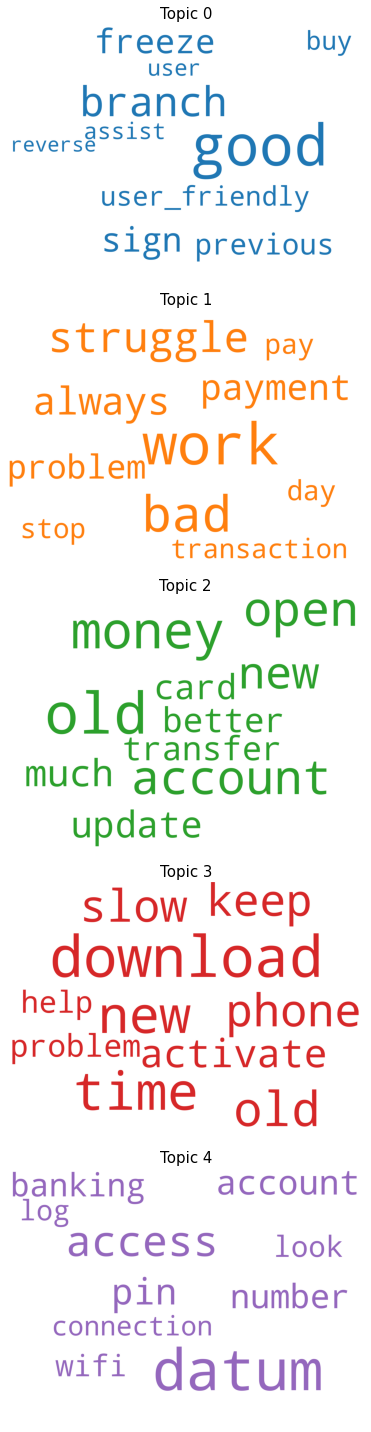

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)



fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=15))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('neg_Capitec_wordcloud_plot.png', dpi=300)
plt.show()

## 1.b Analyse the pattern in your generated topics over time and explain your observation to management.

In [ ]:
  def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_cap_neg):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords_pos = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords_pos.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7262,"work, bad, struggle, always, payment, problem,...","[aware, problem, work, hard, fix, never, probl..."
1,1,3.0,0.4503,"download, time, new, old, phone, slow, keep, a...","[horrible, experience, always, offline, able, ..."
2,2,3.0,0.5371,"download, time, new, old, phone, slow, keep, a...","[alot, people, complain, issue, still, fix, cl..."
3,3,3.0,0.4385,"download, time, new, old, phone, slow, keep, a...","[alot, people, complain, issue, still, fix, cl..."
4,4,1.0,0.4518,"work, bad, struggle, always, payment, problem,...","[application, keep, talk, money, able, access,..."
5,5,3.0,0.5997,"download, time, new, old, phone, slow, keep, a...","[keep, must, connect, internet, wifi, restart,..."
6,6,1.0,0.7032,"work, bad, struggle, always, payment, problem,...","[seriously, deal, unavailable, time, business,..."
7,7,1.0,0.6234,"work, bad, struggle, always, payment, problem,...","[love, day, bank, solve, issue, year, day, mon..."
8,8,1.0,0.4682,"work, bad, struggle, always, payment, problem,...","[struggle, access, account, day, log, otherwis..."
9,9,4.0,0.4782,"datum, access, pin, account, number, banking, ...","[work, anymore, keep, connection, issue, open,..."


In [ ]:
df_dominant_topic['Date'] = pd.to_datetime(data_cap_neg['Date_Posted'])
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date
9556,9556,2.0,0.3372,"old, money, open, account, new, much, update, ...","[show, account, balance, click, route, page, s...",2020-08-11 14:57:00
462,462,4.0,0.7984,"datum, access, pin, account, number, banking, ...","[allow, anymore, datum]",2021-09-11 16:07:00
6242,6242,3.0,0.5969,"download, time, new, old, phone, slow, keep, a...","[guy, please, old, banking, one, help, allow, ...",2021-04-25 07:16:00
6706,6706,2.0,0.4402,"old, money, open, account, new, much, update, ...","[like, face, opening, security]",2021-05-27 17:27:00
5775,5775,0.0,0.3000,"good, branch, sign, freeze, previous, user_fri...","[stuck, fix, bug]",2020-05-24 22:29:00
7628,7628,0.0,0.5334,"good, branch, sign, freeze, previous, user_fri...","[like, infected, virus]",2021-02-28 08:56:00
9194,9194,3.0,0.3852,"download, time, new, old, phone, slow, keep, a...","[previous, capitec, logo, top, show, new, open...",2021-08-09 22:30:00
9254,9254,3.0,0.5735,"download, time, new, old, phone, slow, keep, a...","[look, good, problem, example, delete, benefit...",2021-05-02 12:57:00
9387,9387,1.0,0.3684,"work, bad, struggle, always, payment, problem,...","[trouble, last, stage, activation, branch, wai...",2021-05-01 08:52:00
8584,8584,1.0,0.6000,"work, bad, struggle, always, payment, problem,...",[ever],2019-12-29 07:25:00


Text(0.5, 1.0, 'How what people disliked about Capitec changed over time')

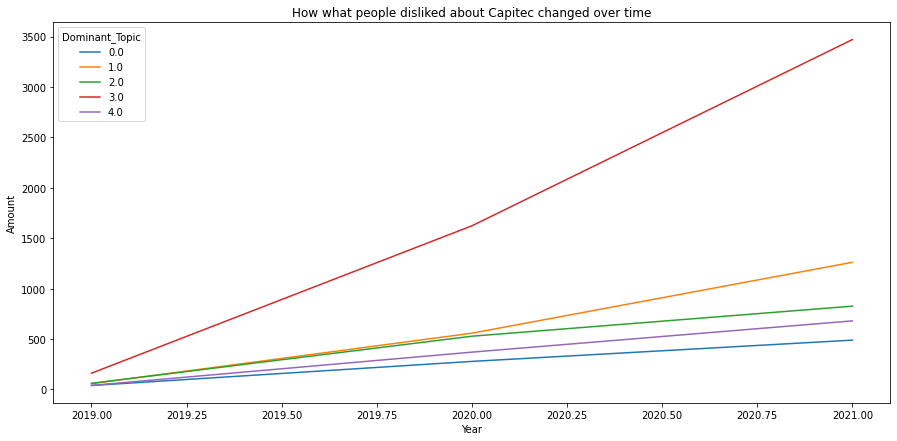

In [ ]:
# plot data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_dominant_topic.groupby([(df_dominant_topic.Date.dt.year),(df_dominant_topic["Dominant_Topic"])]).size().unstack().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
ax.set_title('How what people disliked about Capitec changed over time')


## 2. Using only the positive reviews (4-5 stars) from Capitec and ABSA, create a topic model with five topics.

In [ ]:
data_pos_ = data_.loc[data_['score'] > 3]
data_pos_.sample(10)

,appId,Date_Posted,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,sortOrder,thumbsUpCount,userImage,userName
46439,com.barclays.absa.banking,2020/12/17 07:42,EASY EFFICIENT & SECURE,NaN,NaN,NaN,gp:AOqpTOFvpnu5rjU2JtIjx21vHC9Eq8oOjoPvyDc-vss...,5,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Monnapule tom Kwamongwe
14119,capitec.acuity.mobile.prod,2021/08/15 20:12,Simple and it is useful,2021/08/16 08:10,"Thanks for the awesome review, Sabelo! We work...",2.0.91,gp:AOqpTOGDrP-I6yFxXPSmrRRnBhjwuaCBQv2fNj69QeJ...,5,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Sabelo Mabunu
48186,com.barclays.absa.banking,2021/04/29 06:53,Good App,NaN,NaN,6.20.0,gp:AOqpTOFzGlO47stswO41VE-q1IQ4h0ZhK7nR5YWtKLX...,5,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Mncedisi Mashwama
35729,com.barclays.absa.banking,2019/09/02 06:56,Good,NaN,NaN,6.6.5,gp:AOqpTOHDOo4LBmW2OcJTlEQB37IRKxT3zY-A0KNYPS6...,4,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Marius Knoetze
49383,com.barclays.absa.banking,2020/12/17 16:19,very good,NaN,NaN,6.17.1,gp:AOqpTOE-ThIuDQAx3qyZaJeNRpj8lmUePy89TMglq_C...,5,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Linda Schultz-smit
56087,com.barclays.absa.banking,2019/02/12 10:38,Marvelous,2019/02/18 11:40,"Hi Mzioxolo, thanks for the awesome rating - w...",NaN,gp:AOqpTOFzVbWL4JHMIbDFTqs_Km2cpKPzfL9ILSkf2lB...,5,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Mzioxolo Jantjie
51914,com.barclays.absa.banking,2020/03/07 12:40,Good,NaN,NaN,6.11.3,gp:AOqpTOF0LPmdGAOhN6dLSunx5LbpHC_IbJjfWmBPXp0...,5,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Lisa Hibbins
43123,com.barclays.absa.banking,2020/01/15 20:49,Awesome and convenient,NaN,NaN,6.10.1,gp:AOqpTOH3hnse0CcJnGlOueCimr_mobF4Fnn-GKeoG1U...,5,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Ricci Ricardo
23747,capitec.acuity.mobile.prod,2019/11/26 14:49,I want it,2019/11/27 09:09,"Hi Jennifer, you may download the app from the...",NaN,gp:AOqpTOGAhSxR1XbvIb_38lmUbAxxFgudXJxsy5_f-5D...,5,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Jennifer Shalati
24749,capitec.acuity.mobile.prod,2020/08/14 15:13,Awesome,NaN,NaN,NaN,gp:AOqpTOEuRmz8jSSBjlEpc7AmcegPbUFu3Q27gJdKoaK...,5,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Ntlele Karabo


In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub('[^a-zA-Z0-9]',' ',sent) # remove non english words
        sent = re.sub('\s+',' ',sent) # remove non english words
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data_pos = data_pos.content.values.tolist()
data_words_pos = list(sent_to_words(data_pos))
print(data_words_pos[:1])

[['had', 'no', 'problems', 'whatsoever', 'with', 'this', 'app', 'very', 'straight', 'forward', 'easy', 'to', 'use', 'and', 'secure', 'but', 'the', 'last', 'week', 'cannot', 'accesd', 'my', 'account', 'through', 'the', 'app', 'deleted', 'the', 'app', 'yesterday', 'and', 'downloaded', 'it', 'again', 'but', 'now', 'it', 'keeps', 'asking', 'my', 'bank', 'account', 'details', 'need', 'to', 'do', 'efts', 'urgently', 'from', 'tomorrow', 'and', 'the', 'nearest', 'capitec', 'bank', 'is', 'kms', 'from', 'me', 'can', 'you', 'please', 'assist', 'or', 'is', 'there', 'problem', 'with', 'capitec', 'online']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_pos, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_pos], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready_pos = process_words(data_words_pos)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
id2word_pos = corpora.Dictionary(data_ready_pos)

# Create Corpus: Term Document Frequency
corpus_pos = [id2word_pos.doc2bow(text) for text in data_ready_pos]

In [ ]:
# Build LDA model
lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           

pprint(lda_model_pos.print_topics())

[(0,
  '0.392*"excellent" + 0.123*"easy" + 0.059*"perfect" + 0.055*"banking" + '
  '0.046*"amazing" + 0.045*"convenient" + 0.033*"service" + 0.018*"fast" + '
  '0.011*"always" + 0.007*"manage"'),
 (1,
  '0.028*"account" + 0.023*"really" + 0.022*"simple" + 0.019*"absa" + '
  '0.018*"quick" + 0.018*"efficient" + 0.017*"wonderful" + 0.016*"feature" + '
  '0.014*"feel" + 0.014*"help"'),
 (2,
  '0.294*"great" + 0.074*"work" + 0.042*"well" + 0.037*"new" + 0.034*"update" '
  '+ 0.030*"look" + 0.024*"problem" + 0.021*"ever" + 0.021*"cool" + '
  '0.020*"happy"'),
 (3,
  '0.202*"love" + 0.054*"exceptional" + 0.049*"absa" + 0.035*"bank" + '
  '0.031*"brilliant" + 0.028*"time" + 0.024*"useful" + 0.023*"helpful" + '
  '0.019*"best" + 0.019*"give"'),
 (4,
  '0.662*"good" + 0.052*"friendly" + 0.031*"much" + 0.025*"life" + '
  '0.019*"user" + 0.016*"awesome" + 0.010*"job" + 0.008*"faster" + '
  '0.008*"better" + 0.006*"absolutely"')]


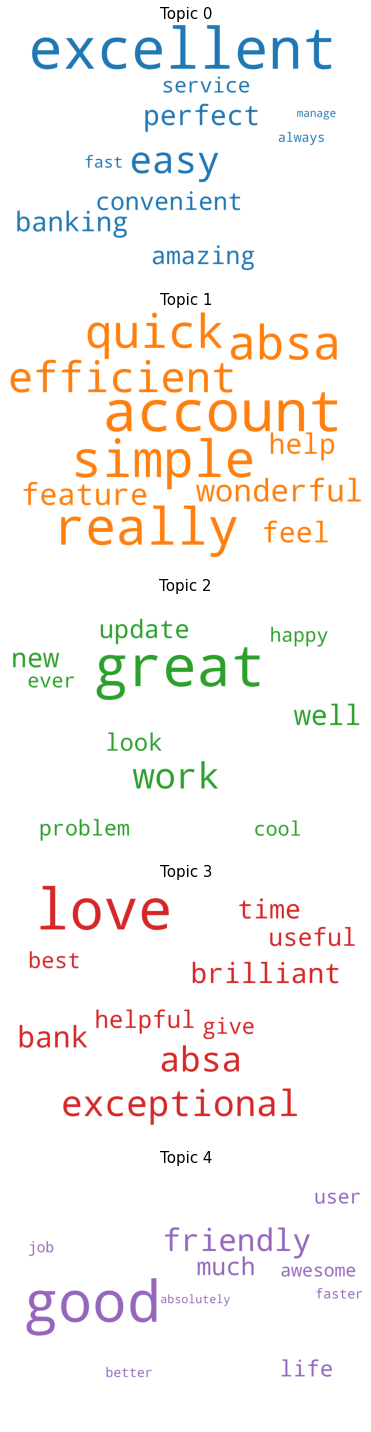

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_pos.show_topics(formatted=False)



fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=15))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('pos_wordcloud_plot.png', dpi=300)
plt.show()

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus_pos, texts=data_pos_):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords_pos = format_topics_sentences(ldamodel=lda_model_pos, corpus=corpus_pos, texts=data_ready_pos)

# Format
df_dominant_topic_Pos = df_topic_sents_keywords_pos.reset_index()
df_dominant_topic_Pos.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_Pos.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5108,"account, really, simple, absa, quick, efficien...","[problem, whatsoever, easy, secure, last, week..."
1,1,1.0,0.8031,"account, really, simple, absa, quick, efficien...","[simple, straight, foward, suppose, however, m..."
2,2,1.0,0.5022,"account, really, simple, absa, quick, efficien...","[root, check, faulty, phone, root, check, abso..."
3,3,1.0,0.5018,"account, really, simple, absa, quick, efficien...","[great, however, possible, remove, saving, pla..."
4,4,2.0,0.3187,"great, work, well, new, update, look, problem,...","[notice, bank, moment, idea, update, tend, bad..."
5,5,1.0,0.6553,"account, really, simple, absa, quick, efficien...","[easy, find, disturb, easyequitie, able, buy, ..."
6,6,1.0,0.5215,"account, really, simple, absa, quick, efficien...","[work, exceptionally, well, find, frustrating,..."
7,7,1.0,0.6407,"account, really, simple, absa, quick, efficien...","[good, show, transaction, feature, able, trans..."
8,8,1.0,0.8265,"account, really, simple, absa, quick, efficien...","[dev, payment, appear, history, last, pay, inf..."
9,9,1.0,0.4708,"account, really, simple, absa, quick, efficien...","[happy, appear, home, screen, playstore, type,..."


In [ ]:
df_dominant_topic_Pos['App'] = data_pos_['appId']

Text(0, 0.5, 'Value')

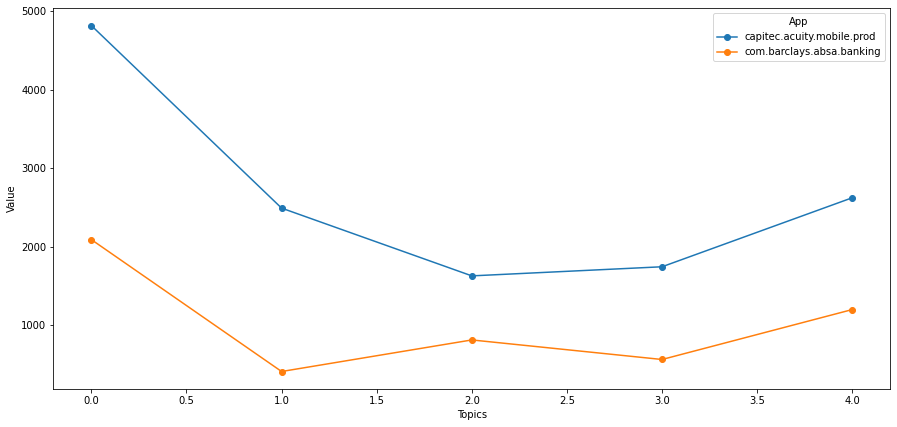

In [ ]:
df1 = df_dominant_topic_Pos
# plot data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df1.groupby(['Dominant_Topic','App']).size().unstack().plot(ax=ax, style="-o")
ax.set_xlabel('Topics')
ax.set_ylabel('Value')